In [2]:
from Graph import AdjacencyGraph
from SimulatedAnnealing import SA
import networkx
import numpy as np
from itertools import product
from tqdm import tqdm
import pickle
import multiprocess
import psutil
from pprint import pprint
from copy import deepcopy
from matplotlib import pyplot as plt
from datetime import timedelta 


# ======================================================================================
#e = networkx.dorogovtsev_goltsev_mendes_graph(4).edges 
# best obtained is 552.1, k=4
# optimal solution is 530.6, k=3
# ======================================================================================
e = networkx.desargues_graph().edges 
# best obtained is optimal
# it is a bipartite graph, so optimal solution is 239, k=2
# ======================================================================================

g = AdjacencyGraph(e)

cost_map = {
    0: 11.7,
    1: 12.2,
    2: 14,
    3: 14.1,
    4: 14.7,
    5: 15.0,
    6: 21.1,
    7: 23.1,
    8: 43.1,
    9: 43.2,
} | {
    c: 100 for c in range(10, 200)
}

print(g.summary(cost_map=cost_map))

20-colored graph;Proper coloring (No violations); With cost 1212.200


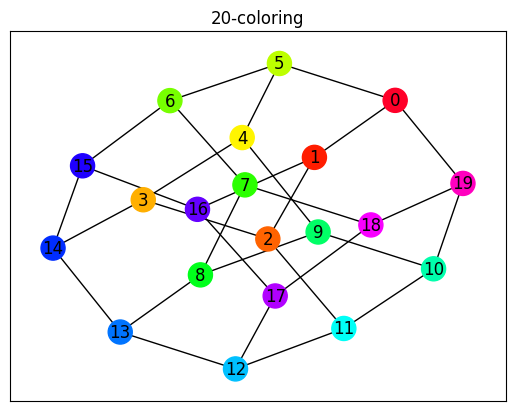

In [3]:
g.plot()
plt.show()

In [11]:
def grid_search_explore_parameters(
    g,
    cost_map,
    iter_limit,
    fname,
    folds = 1,
    mp_threads = max(psutil.cpu_count() - 1, 1),
    temperature_grid = range(1, 11, 1),
    decay_and_param = [
        (['linear'], np.arange(0.001, 0.005, 0.001)), 
        (['decay'], np.arange(0.9, 0.99, 0.01)), 
        (['factor'], [0.8, 0.9]),
    ],
    optimal_cost_estimation: float = None,
    print_enabled = False,
    deadline = None
    ):

    grid = []
    for (method, k_range) in decay_and_param:
        grid += list(product(method, k_range))
    grid = list(product(list(temperature_grid), grid))

    print(f'Starting grid search for total of {len(grid)} combinations and {folds} folds...')


    grid_results = {}


    def do_gs_execution(args):

        temperature, (reduction_mode, k_value) = args
        
        g_local = deepcopy(g)
        coloring_cost = []
        for i in range(folds):
            best_coloring, _history = SA(
                g_local,
                cost_map,
                iter_limit,
                temperature=temperature,
                temperature_reduction_method=reduction_mode,
                temperature_k=k_value,
                optimal_cost_estimation=optimal_cost_estimation,
                print_enabled=print_enabled,
                deadline=deadline/folds
            )

            coloring_cost.append( g_local.apply_coloring(best_coloring).coloring_cost(cost_map) )
            print(f'Finished fold {i} with args: {args}')
        
        print(f'Finished configuration with args: {args}')
        return (coloring_cost, np.std(coloring_cost))

    
    if mp_threads > 1:
        print(f'Starting Multiprocess GridSearch with {mp_threads} threads')
    with multiprocess.Pool(mp_threads) as p:

        res = p.map(do_gs_execution, grid)


    grid_results = {str(gs_args) : r for (gs_args, r) in zip(grid, res)}

        
    with open(fname, 'wb') as f:
        pickle.dump(grid_results, f)


    return grid_results



In [12]:
gs_results = grid_search_explore_parameters(
    g,
    cost_map,
    None,
    'desargues_SA_gs_results_240sec-2fold.pickle',
    print_enabled=False,
    optimal_cost_estimation=239,
    deadline=timedelta(minutes=4),
    folds=2,
)

pprint(gs_results)

srt = list(
    sorted(
        list(
            zip(gs_results.keys(), gs_results.values())
        ),
        key=lambda tpl: np.mean(tpl[1][0]),    
    )
)
print('='*100)
for (conf, (results, std)) in srt:
    print(f'Conf: {conf}: mean result: {np.mean(results):.3f} ({std:.3f} std) ({results})')

Starting grid search for total of 150 combinations and 2 folds...
Starting Multiprocess GridSearch with 9 threads
Finished fold 0 with args: (1, ('linear', 0.001))
Finished fold 1 with args: (1, ('linear', 0.001))
Finished configuration with args: (1, ('linear', 0.001))
Finished fold 0 with args: (2, ('linear', 0.001))
Finished fold 1 with args: (2, ('linear', 0.001))
Finished configuration with args: (2, ('linear', 0.001))
Finished fold 0 with args: (3, ('linear', 0.001))
Finished fold 1 with args: (3, ('linear', 0.001))
Finished configuration with args: (3, ('linear', 0.001))
Finished fold 0 with args: (2, ('decay', 0.91))Finished fold 0 with args: (1, ('decay', 0.91))

Finished fold 1 with args: (2, ('decay', 0.91))Finished fold 1 with args: (1, ('decay', 0.91))
Finished fold 0 with args: (3, ('decay', 0.9600000000000001))
Finished configuration with args: (2, ('decay', 0.91))
Finished configuration with args: (1, ('decay', 0.91))
Finished fold 1 with args: (3, ('decay', 0.960000000